# K-Nearest Neighbors (KNN) and Logistic Regression

We are going to apply a **KNN** and a **Logistic Regression** for classification on a dataset about COVID 19.


**K-Nearsest Neighbors (KNN)**
<img src="files/figures/KNN.jpg" width="350px"/>

https://fr.wikipedia.org/wiki/M%C3%A9thode_des_k_plus_proches_voisins

**Logistic Regression**
<img src="files/figures/LogReg.jpg" width="450px"/>

https://medium.datadriveninvestor.com/logistic-regression-explained-f51d32be904e

## Libraries

In [248]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, plot_roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

## Data

- Download the **COVID-19 patient pre-condition dataset** (csv file) kaggle:<br>
https://www.kaggle.com/datasets/tanmoyx/covid19-patient-precondition-dataset
- Import the data and look at them with `pandas`.
- The goal is to predict the binary column `"icu"` (Intensive Care Units) using the other columns.
- Check pairwise correlations among variables.

In [252]:
df = pd.read_csv('../z_data/covid/covid.csv')

In [253]:
df.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [254]:
df.shape

(566602, 23)

## Data Preprocessing

- Check if there are missing values.
- Drop the column `"id"`.
- Drop the lines where the target variable `"icu"` is non applicable (=97), ignored (=98) or non specified (=99).
- For every binary variables, replace the values that are not 1 or 2 by np.nan; then replace all 2's by 0's.<br>
(cf. file catalogs.xlsx for further details).
- Split the data into train and test sets (80%/20%) (`train_test_split()`).
- Replace missig data (`np.nan`) by their medians.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html<br>
Fit an "imputer" *on the train set* and then transform both train and test sets.

In [255]:
# Check NaN values
df.isnull().sum().any()

False

In [184]:
# Drop id column
df = df.drop(labels=['id'], axis=1)

In [185]:
df.head()

,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,2,...,2,2,2,2,2,2,2,2,1,97
1,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,2,...,2,2,2,2,2,2,2,99,1,97
2,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,2,...,2,2,2,2,1,2,2,99,1,2
3,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,2,...,2,2,2,2,2,2,2,99,1,2
4,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,1,...,2,1,2,1,2,2,2,99,1,2


In [187]:
df.describe()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
count,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000
mean,1.506726,1.215165,76.562952,1.846262,42.622483,50.400692,2.210633,2.280221,2.265029,2.319628,2.145774,2.410030,2.286157,2.138905,2.283765,2.238360,31.573034,1.728651,76.562864
std,0.499955,0.410937,39.058676,0.560939,16.659973,47.501579,5.683523,5.327832,5.334658,5.667381,5.459866,6.489959,5.438405,5.395578,5.393232,5.571901,45.082123,0.658710,39.059060
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,97.000000,2.000000,31.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,97.000000
50%,2.000000,1.000000,97.000000,2.000000,41.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,97.000000
75%,2.000000,1.000000,97.000000,2.000000,53.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,97.000000
max,2.000000,2.000000,99.000000,99.000000,120.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000


In [188]:
df.dtypes

sex                     int64
patient_type            int64
entry_date             object
date_symptoms          object
date_died              object
intubed                 int64
pneumonia               int64
age                     int64
pregnancy               int64
diabetes                int64
copd                    int64
asthma                  int64
inmsupr                 int64
hypertension            int64
other_disease           int64
cardiovascular          int64
obesity                 int64
renal_chronic           int64
tobacco                 int64
contact_other_covid     int64
covid_res               int64
icu                     int64
dtype: object

In [189]:
df.icu.value_counts()

97    444689
2     111676
1      10112
99       125
Name: icu, dtype: int64

In [190]:
# Target variable: remove non applicable (97), ignored (98) and non specified (99) data.
df = df[df.icu <= 2]

In [191]:
df.icu.value_counts() # imbalaced data!

2    111676
1     10112
Name: icu, dtype: int64

In [192]:
# Everywhere: replace 97, 98, 99 by NaNs
df = df.replace(97, np.nan)
df = df.replace(98, np.nan)
df = df.replace(99, np.nan)

In [193]:
# For every binary variable, replace 2 (=NO) by 0

In [194]:
df.columns

Index(['sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu'],
      dtype='object')

In [195]:
cols_to_replace = ['sex', 'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu']

In [196]:
for col in cols_to_replace:
    df[col] = df[col].apply(lambda x : 0 if x == 2 else x)

In [197]:
df.head()

,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
2,1,2,06-04-2020,01-04-2020,9999-99-99,0,0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,1,0
3,0,2,17-04-2020,10-04-2020,9999-99-99,0,1,30.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0
4,1,2,13-04-2020,13-04-2020,22-04-2020,0,0,60.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,1,0
5,0,2,16-04-2020,16-04-2020,29-04-2020,0,1,47.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,1
6,0,2,22-04-2020,13-04-2020,9999-99-99,0,0,63.0,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0


In [198]:
# Remove data variables
df = df.drop(columns=['entry_date', 'date_symptoms', 'date_died'])

In [199]:
df.columns

Index(['sex', 'patient_type', 'intubed', 'pneumonia', 'age', 'pregnancy',
       'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension',
       'other_disease', 'cardiovascular', 'obesity', 'renal_chronic',
       'tobacco', 'contact_other_covid', 'covid_res', 'icu'],
      dtype='object')

<AxesSubplot:>

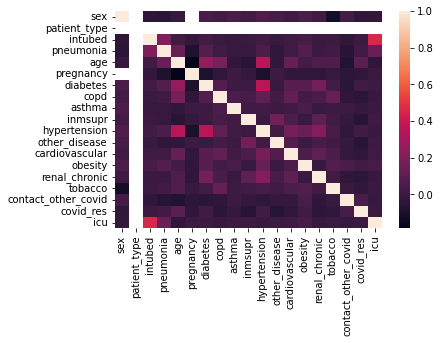

In [200]:
# Check correlations
sns.heatmap(df.corr())

- Split and Impute Data

In [207]:
# Features and target
X = df.drop(labels=["icu"], axis=1)
y = df["icu"]

In [208]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97430, 18), (24358, 18), (97430,), (24358,))

In [210]:
# Impute missing data by median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

## K-Nearest Neighbors

- Instanciate a **KNN** (`KNeighborsClassifier()`).
- Do a **grid search with cross validation** on the nb of neighbors for 1 to 15 (`GridSearchCV()`):<br>
`np.arange(1, 15)`.
- Using the best model obtained via grid search, compute the **predictions** on the train and test sets.
- Compute the **classification reports** on the train and test sets (`classification_report`) and **ROC curve** on the test set (`plot_roc_curve`).

In [267]:
# Instanciate a KNN
# Grid search over k
knn = KNeighborsClassifier()

param_grid = {"n_neighbors": np.arange(1, 15)}
knn_gscv = GridSearchCV(knn, param_grid, cv=3) # 3 fold CV
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [261]:
# Check best model
knn_gscv.best_params_

{'n_neighbors': 14}

In [262]:
y_train_preds = knn_gscv.predict(X_train)
y_test_preds = knn_gscv.predict(X_test)

In [263]:
print("Train results")

print(classification_report(y_train, y_train_preds))

Train results
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     89354
           1       0.70      0.09      0.16      8076

    accuracy                           0.92     97430
   macro avg       0.81      0.54      0.56     97430
weighted avg       0.90      0.92      0.89     97430



In [264]:
print("Train results")

print(classification_report(y_test, y_test_preds))

Train results
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22322
           1       0.60      0.07      0.13      2036

    accuracy                           0.92     24358
   macro avg       0.76      0.53      0.54     24358
weighted avg       0.90      0.92      0.89     24358



/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


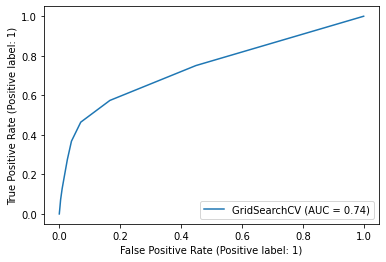

In [265]:
plot_roc_curve(knn_gscv, X_test, y_test) 
plt.show()

## Logistic Regression

- Instanciate a **logistic regression** (`LogisticRegression()`).
- Do a **grid search with cross validation** on the regularization parameter `C` from 1e-3 to 1e+3 (`GridSearchCV()`):<br>
`np.logspace(-3, 3, num=7)`.
- Using the best model obtained via grid search, compute the predictions on the train and test sets.
- Compute the **classification reports** on the train and test sets (`classification_report`) and **ROC curve** on the test set (`plot_roc_curve`).

In [266]:
np.logspace(-3, 3, num=7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [238]:
lr = LogisticRegression(solver='liblinear')

C=1.0,
param_grid = {"C": np.logspace(-3, 3, num=7)} # logspace search
lr_gscv = GridSearchCV(lr, param_grid, cv=3) # 3 fold CV
lr_gscv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [260]:
# Check best model
lr_gscv.best_params_

{'C': 1.0}

In [259]:
y_train_preds = lr_gscv.predict(X_train)
y_test_preds = lr_gscv.predict(X_test)

In [257]:
print("Train results")

print(classification_report(y_train, y_train_preds))

Train results
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     89354
           1       0.54      0.27      0.36      8076

    accuracy                           0.92     97430
   macro avg       0.74      0.63      0.66     97430
weighted avg       0.90      0.92      0.91     97430



In [258]:
print("Train results")

print(classification_report(y_test, y_test_preds))

Train results
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     22322
           1       0.54      0.27      0.36      2036

    accuracy                           0.92     24358
   macro avg       0.74      0.63      0.66     24358
weighted avg       0.90      0.92      0.91     24358



/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


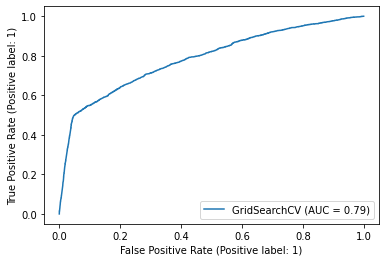

In [249]:
plot_roc_curve(lr_gscv, X_test, y_test) 
plt.show()